# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
#importing required libraries
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from keras import optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 # We experimented with batch size of 64 & 32, a batch size of 32 was faster, other batch sizes gave us OOM (Out of memory error)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with some of the parts of the generator function such that you get high accuracy.

Converts images size to (120,120,3)
Also, normalized each frame with mean value of each RGB from imagenet dataset.
Did not use mean from Gesture recognition as data is very less.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. You might want to use `TimeDistributed`, `GRU` and other RNN structures after doing transfer learning. Also remember that the last layer is the softmax. Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

# VGGNet + RNN Layers (Time distributed)

# Model-1 

Used VGG16, initialized weights with imagenet.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

#Training VGG model using Transfer Learning

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
callbacks_list = [checkpoint, LR]

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - 56s 3s/step - loss: 1.7372 - categorical_accuracy: 0.2032 - val_loss: 1.6412 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_conv_lstm_2020-09-1404_44_54.815517/model-00001-1.73806-0.20362-1.64117-0.19000.h5
Epoch 2/10
21/21 [==============================] - 32s 2s/step - loss: 1.6558 - categorical_accuracy: 0.2475 - val_loss: 1.5966 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_conv_lstm_2020-09-1404_44_54.815517/model-00002-1.65623-0.24736-1.59660-0.22000.h5
Epoch 3/10
21/21 [==============================] - 32s 2s/step - loss: 1.5705 - categorical_accuracy: 0.2944 - val_loss: 1.4920 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_conv_lstm_2020-09-1404_44_54.815517/model-00003-1.57125-0.29261-1.49198-0.38000.h5
Epoch 4/10
21/21 [================

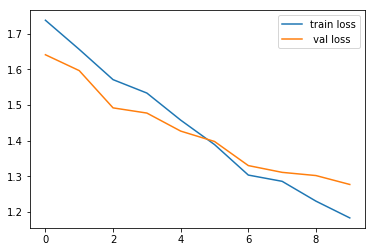

In [16]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

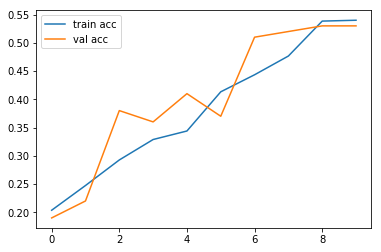

In [17]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Model-2
Increased Epoch to 20 to the same model

In [18]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

            
## Print Artifacts ##

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

## Load the train & val data via generators ##

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


## Model Saving ##

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
callbacks_list = [checkpoint, LR]

## Data load ##

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [19]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_3 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_4 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [20]:
num_epochs = 20
print ('# epochs =', num_epochs)

# epochs = 20


In [21]:
 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 43s 2s/step - loss: 1.8078 - categorical_accuracy: 0.2025 - val_loss: 1.6451 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_conv_lstm_2020-09-1404_55_04.408922/model-00001-1.80908-0.20060-1.64510-0.19000.h5
Epoch 2/20
21/21 [==============================] - 37s 2s/step - loss: 1.6411 - categorical_accuracy: 0.2606 - val_loss: 1.5562 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_conv_lstm_2020-09-1404_55_04.408922/model-00002-1.63975-0.25943-1.55621-0.30000.h5
Epoch 3/20
21/21 [==============================] - 37s 2s/step - loss: 1.5107 - categorical_accuracy: 0.3445 - val_loss: 1.4629 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to model_init_conv_lstm_2020-09-1404_55_04.408922/model-00003-1.51136-0.34389-1.46292-0.36000.h5
Epoch 4/20
21/21 [================

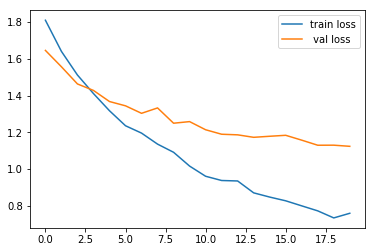

In [24]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

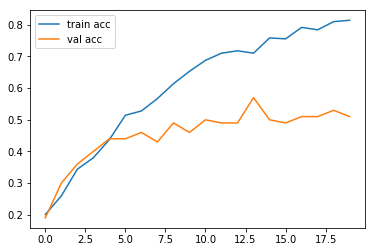

In [25]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

The Model overfits, but lets check by increasing the epoch once more.

# Model-3
Increased the Epochs to 30


In [26]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

            
## Print Artifacts ##

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

## Load the train & val data via generators ##

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


## Model Saving ##

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
callbacks_list = [checkpoint, LR]

## Data load ##

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [27]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_5 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_6 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [28]:
num_epochs = 30
print ('# epochs =', num_epochs)

# epochs = 30


In [29]:
 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 44s 2s/step - loss: 1.7577 - categorical_accuracy: 0.2220 - val_loss: 1.6364 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_conv_lstm_2020-09-1405_10_57.769807/model-00001-1.75620-0.22323-1.63641-0.27000.h5
Epoch 2/30
21/21 [==============================] - 35s 2s/step - loss: 1.6564 - categorical_accuracy: 0.2507 - val_loss: 1.5608 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_conv_lstm_2020-09-1405_10_57.769807/model-00002-1.65979-0.24887-1.56077-0.31000.h5
Epoch 3/30
21/21 [==============================] - 36s 2s/step - loss: 1.5353 - categorical_accuracy: 0.3145 - val_loss: 1.5320 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model_init_conv_lstm_2020-09-1405_10_57.769807/model-00003-1.53356-0.31523-1.53197-0.32000.h5
Epoch 4/30
21/21 [================

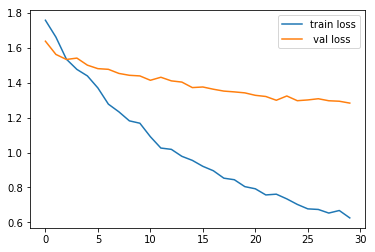

In [30]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

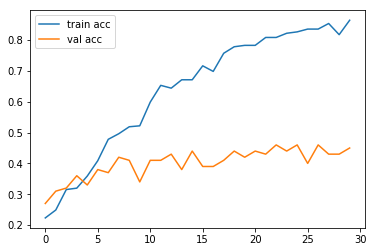

In [31]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

Seems overfitting, let try changing the LR

# Model 4
Changing the LR

In [32]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

            
## Print Artifacts ##

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

## Load the train & val data via generators ##

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


## Model Saving ##

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
callbacks_list = [checkpoint, LR]

## Data load ##

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [33]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

In [34]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_7 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_8 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [35]:
num_epochs = 30
print ('# epochs =', num_epochs)

# epochs = 30


In [36]:
 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/trainEpoch 1/30 ; batch size = 32

21/21 [==============================] - 44s 2s/step - loss: 1.5817 - categorical_accuracy: 0.2980 - val_loss: 1.4185 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_conv_lstm_2020-09-1405_32_19.881424/model-00001-1.58397-0.29563-1.41852-0.43000.h5
Epoch 2/30
21/21 [==============================] - 35s 2s/step - loss: 1.3797 - categorical_accuracy: 0.4210 - val_loss: 1.2460 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_conv_lstm_2020-09-1405_32_19.881424/model-00002-1.37970-0.42081-1.24602-0.54000.h5
Epoch 3/30
21/21 [==============================] - 36s 2s/step - loss: 1.2534 - categorical_accuracy: 0.4712 - val_loss: 1.2139 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_conv_lstm_2020-09-1405_32_19.881424/model-00003-1.25617-0.47059-1.21391-0.49000.h5
Epoch 4/30
21/21 [================

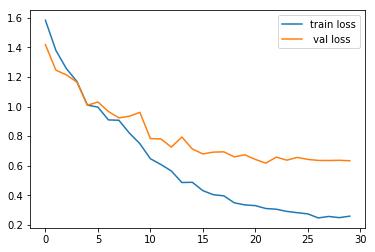

In [37]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

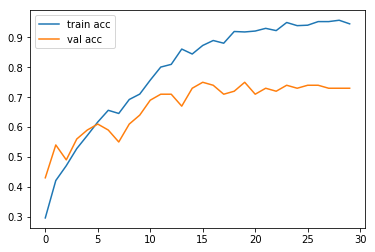

In [38]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Model-5
Playing with decay Rate and learning Rate

In [39]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

            
## Print Artifacts ##

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

## Load the train & val data via generators ##

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


## Model Saving ##

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
callbacks_list = [checkpoint, LR]

## Data load ##

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [40]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

In [41]:
learning_rate = 0.1
decay_rate = learning_rate / num_epochs
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_9 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_10 (GRU)                 (None, 16)                2352      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [42]:
 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Epoch 1/30
Project_data/train ; batch size = 32
21/21 [==============================] - 43s 2s/step - loss: 1.6922 - categorical_accuracy: 0.1831 - val_loss: 1.6012 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_conv_lstm_2020-09-1405_54_17.464154/model-00001-1.69323-0.18100-1.60121-0.19000.h5
Epoch 2/30
21/21 [==============================] - 35s 2s/step - loss: 1.6167 - categorical_accuracy: 0.2226 - val_loss: 1.6243 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_conv_lstm_2020-09-1405_54_17.464154/model-00002-1.61681-0.22323-1.62429-0.21000.h5
Epoch 3/30
21/21 [==============================] - 36s 2s/step - loss: 1.6258 - categorical_accuracy: 0.1794 - val_loss: 1.6044 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_conv_lstm_2020-09-1405_54_17.464154/model-00003-1.62607-0.17949-1.60444-0.23000.h5

Epoch 00003: ReduceLROnPlateau re

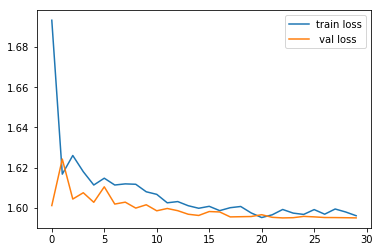

In [43]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

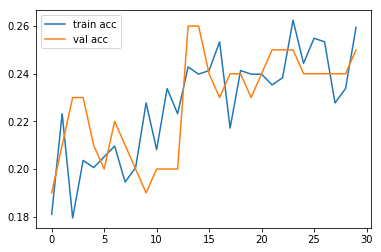

In [44]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Model-6
Using more epoch of 50 in the same model as above

In [45]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

            
## Print Artifacts ##

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

## Load the train & val data via generators ##

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


## Model Saving ##

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
callbacks_list = [checkpoint, LR]

## Data load ##

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [46]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

In [49]:
#Model Compilation 
learning_rate = 0.01
decay_rate = learning_rate / num_epochs
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_11 (GRU)                 (None, 15, 32)            9312      
_________________________________________________________________
gru_12 (GRU)                 (None, 16)                2352      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [50]:
num_epochs = 50

In [51]:
 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - 45s 2s/step - loss: 1.6428 - categorical_accuracy: 0.2470 - val_loss: 1.5139 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_conv_lstm_2020-09-1406_31_59.409547/model-00001-1.64278-0.24736-1.51387-0.34000.h5
Epoch 2/50
21/21 [==============================] - 34s 2s/step - loss: 1.5459 - categorical_accuracy: 0.3125 - val_loss: 1.4922 - val_categorical_accuracy: 0.3700

Epoch 00002: saving model to model_init_conv_lstm_2020-09-1406_31_59.409547/model-00002-1.54565-0.31373-1.49222-0.37000.h5
Epoch 3/50
21/21 [==============================] - 37s 2s/step - loss: 1.4661 - categorical_accuracy: 0.3754 - val_loss: 1.3560 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_conv_lstm_2020-09-1406_31_59.409547/model-00003-1.46720-0.37406-1.35601-0.55000.h5
Epoch 4/50
21/21 [================

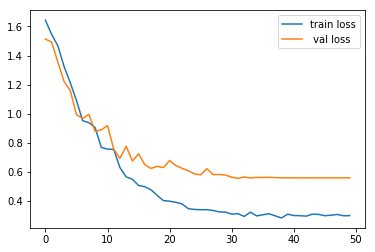

In [52]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

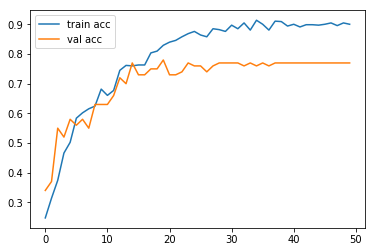

In [53]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Model- 7
Using Adam as the optimizer

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16


## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

            
## Print Artifacts ##

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

## Load the train & val data via generators ##

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


## Model Saving ##

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
callbacks_list = [checkpoint, LR]

## Data load ##

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [7]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

58892288/58889256 [==============================] - 5s 0us/step


In [8]:
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [9]:
 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 154s 7s/step - loss: 1.6988 - categorical_accuracy: 0.2174 - val_loss: 1.5522 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_conv_lstm_2020-09-1408_05_42.611058/model-00001-1.70116-0.21569-1.55217-0.32000.h5
Epoch 2/30
21/21 [==============================] - 33s 2s/step - loss: 1.5249 - categorical_accuracy: 0.3103 - val_loss: 1.3876 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_conv_lstm_2020-09-1408_05_42.611058/model-00002-1.52590-0.30920-1.38756-0.45000.h5
Epoch 3/30
21/21 [==============================] - 33s 2s/step - loss: 1.3923 - categorical_accuracy: 0.3672 - val_loss: 1.2554 - val_categorical_accuracy: 0.4800

Epoch 00003: saving model to model_init_conv_lstm_2020-09-1408_05_42.611058/model-00003-1.39175-0.36802-1.25540-0.48000.h5
Epoch 4/30
21/21 [===============

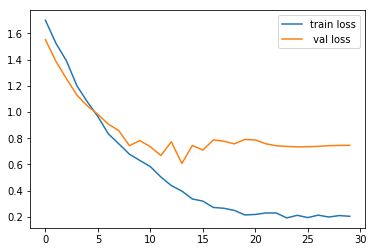

In [13]:
#plot the loss
import matplotlib.pyplot as plt

plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

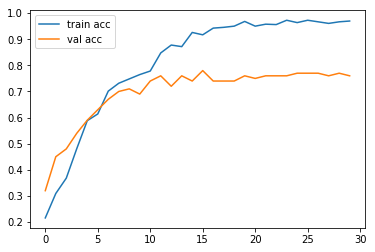

In [12]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Model Conv3d networks
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 64
ablation=100


In [4]:
train_doc.shape

(663,)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with some of the parts of the generator function such that you get high accuracy.

New generator with ablation and Validation parameter

In [5]:
def generator(source_path, folder_list, batch_size, ablation=None,Validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    #img_idx = [x for x in range(0, 30)] 
    while True:
        t = np.random.permutation(folder_list)
        if ablation is not None and Validation==False:
                t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Creating conv3d with relu activation and softmax as output activation for 5 classes. 4 filters nb_filters = 8,16,32,64

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

nb_filters = [8,16,32,64]
nb_dense = [128, 5]

# Input
input_shape=(15,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [7]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 15, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 60, 60, 16)     64        
_________________________________________________________________
activation_2 (Activation)    (None, 7, 60, 60, 16)     0         
__________

In [8]:
ablation=64
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 64
# validation sequences = 100
# epochs = 10


In [9]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [10]:

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 64
# validation sequences = 100
# epochs = 10


In [11]:
print(steps_per_epoch)
print(validation_steps)

1
2


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size,ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size,ablation=None,Validation=True)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

Ablation run for 1st conv3d model with ablation size 64 and 10 epochs

In [28]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Source path =  Project_data/val ; batch size = 64
Source path =  Project_data/train ; batch size = 64
Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 3.2023 - categorical_accuracy: 0.1875 - val_loss: 1.8853 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2020-09-1408_41_30.228745/model-00001-3.20234-0.18750-1.88528-0.18000.h5
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 2.7632 - categorical_accuracy: 0.2344 - val_loss: 1.7484 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-09-1408_41_30.228745/model-00002-2.76315-0.23438-1.74838-0.25000.h5
Epoch 3/10
1/1 [==============================] - 7s 7s/step - loss: 2.9118 - categorical_accuracy: 0.1719 - val_loss: 1.6576 - val_categorical_accuracy: 0.2800

Epoch 00003: saving model to model_init_2020-09-1408_41_30.228745/model-00003-2.91181-0.17188-1.65756-0.28000.h5
Epoch 4/10
1/1 [==============================] - 7s 7s/step - loss: 2.

In [29]:
import matplotlib.pyplot as plt

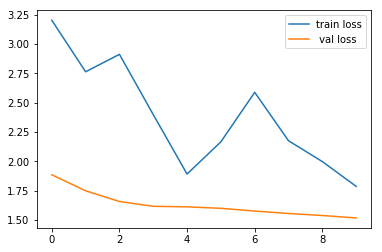

In [30]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

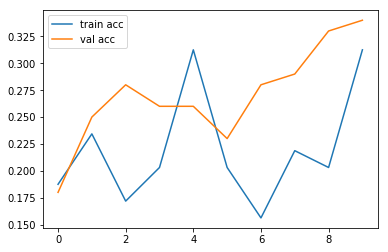

In [31]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

Increasing the number of epochs to 30 for same ablation size

In [32]:

num_epochs = 30
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Epoch 1/30
1/1 [==============================] - 7s 7s/step - loss: 1.7695 - categorical_accuracy: 0.2031 - val_loss: 1.5020 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-09-1408_41_30.228745/model-00001-1.76947-0.20312-1.50199-0.32000.h5
Epoch 2/30
1/1 [==============================] - 7s 7s/step - loss: 2.0740 - categorical_accuracy: 0.2188 - val_loss: 1.5309 - val_categorical_accuracy: 0.3200

Epoch 00002: saving model to model_init_2020-09-1408_41_30.228745/model-00002-2.07402-0.21875-1.53094-0.32000.h5
Epoch 3/30
1/1 [==============================] - 7s 7s/step - loss: 1.8296 - categorical_accuracy: 0.2344 - val_loss: 1.5042 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model_init_2020-09-1408_41_30.228745/model-00003-1.82958-0.23438-1.50421-0.35000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/30
1/1 [==============================] - 7s 7s/step - loss: 1.9033 - categorical_accu

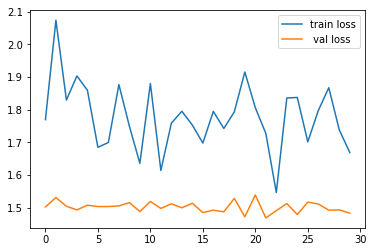

In [33]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

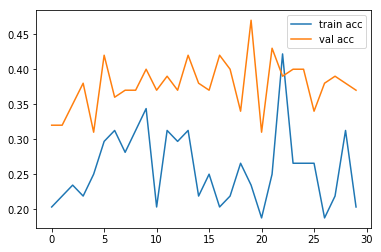

In [34]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Experiment 2

Executing for all 663 traing videos i.e., 663*15 images * 3 for RGB

Epoch 10

In [ ]:
ablation=len(train_doc)
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [38]:
print(steps_per_epoch)
print(validation_steps)

11
2


In [39]:
train_generator = generator(train_path, train_doc, batch_size,ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size,ablation=None,Validation=True)

In [40]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

Used 3 workers to execute model

In [41]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Source path =  Project_data/val ; batch size = 64
Source path =  Project_data/train ; batch size = 64
Epoch 1/10
11/11 [==============================] - 40s 4s/step - loss: 1.7786 - categorical_accuracy: 0.2704 - val_loss: 1.4959 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2020-09-1408_56_06.201064/model-00001-1.77735-0.26848-1.49593-0.39000.h5
Epoch 2/10
11/11 [==============================] - 32s 3s/step - loss: 1.7660 - categorical_accuracy: 0.2281 - val_loss: 1.4956 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2020-09-1408_56_06.201064/model-00002-1.76684-0.22624-1.49558-0.39000.h5
Epoch 3/10
11/11 [==============================] - 33s 3s/step - loss: 1.8118 - categorical_accuracy: 0.2226 - val_loss: 1.4955 - val_categorical_accuracy: 0.3900

Epoch 00003: saving model to model_init_2020-09-1408_56_06.201064/model-00003-1.80225-0.22775-1.49546-0.39000.h5
Epoch 4/10
11/11 [==============================] - 33s 3s/step 

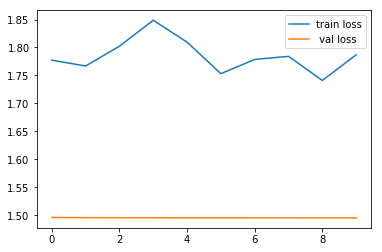

In [43]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

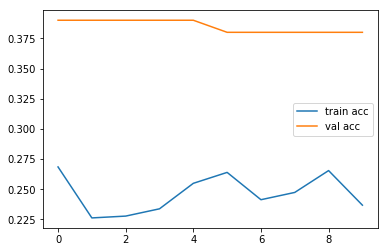

In [44]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

As the model is still underfitting and accuracy is very low, increasing epochs to increase training of weights

In [14]:
#trying with 50 epochs
num_epochs = 50
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Source path =  Project_data/val ; batch size = 64
Source path = Epoch 1/50 Project_data/train ; batch size = 64

1/1 [==============================] - 55s 55s/step - loss: 3.1582 - categorical_accuracy: 0.2500 - val_loss: 1.8127 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-09-1409_18_28.752397/model-00001-3.15825-0.25000-1.81266-0.23000.h5
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 2.7212 - categorical_accuracy: 0.2500 - val_loss: 1.7024 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2020-09-1409_18_28.752397/model-00002-2.72120-0.25000-1.70240-0.21000.h5
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 2.8766 - categorical_accuracy: 0.2188 - val_loss: 1.6340 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2020-09-1409_18_28.752397/model-00003-2.87656-0.21875-1.63402-0.24000.h5
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 2.

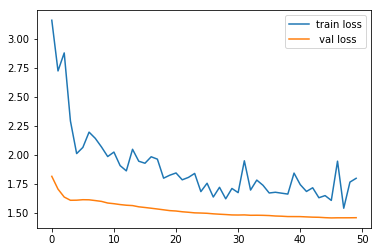

In [17]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

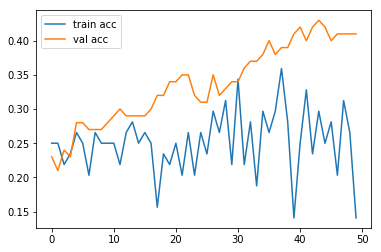

In [18]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

trying with 100 epochs just out of curiosity

In [19]:

num_epochs = 100
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 1.4296 - categorical_accuracy: 0.4062 - val_loss: 1.4493 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-09-1409_18_28.752397/model-00001-1.42964-0.40625-1.44926-0.44000.h5
Epoch 2/100
1/1 [==============================] - 7s 7s/step - loss: 1.7598 - categorical_accuracy: 0.2344 - val_loss: 1.4488 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-09-1409_18_28.752397/model-00002-1.75982-0.23438-1.44884-0.40000.h5
Epoch 3/100
1/1 [==============================] - 7s 7s/step - loss: 1.5601 - categorical_accuracy: 0.2969 - val_loss: 1.4364 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_init_2020-09-1409_18_28.752397/model-00003-1.56005-0.29688-1.43639-0.42000.h5
Epoch 4/100
1/1 [==============================] - 7s 7s/step - loss: 1.6352 - categorical_accuracy: 0.2656 - val_loss: 1.4781 - val_categorical_accuracy: 0.3900

Epoch 000

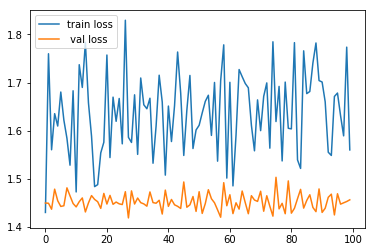

In [20]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

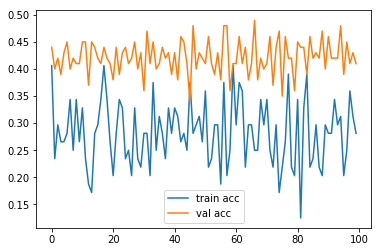

In [21]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Experiment 3

In [22]:
num_epochs=20
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 1.5416 - categorical_accuracy: 0.2344 - val_loss: 1.4510 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-09-1409_18_28.752397/model-00001-1.54158-0.23438-1.45099-0.43000.h5
Epoch 2/20
1/1 [==============================] - 7s 7s/step - loss: 1.7042 - categorical_accuracy: 0.1719 - val_loss: 1.4510 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2020-09-1409_18_28.752397/model-00002-1.70418-0.17188-1.45103-0.43000.h5
Epoch 3/20
1/1 [==============================] - 7s 7s/step - loss: 1.6451 - categorical_accuracy: 0.2812 - val_loss: 1.4510 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2020-09-1409_18_28.752397/model-00003-1.64510-0.28125-1.45102-0.43000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.440892309431682e-19.
Epoch 4/20
1/1 [==============================] - 7s 7s/step - loss: 1.6446 - categorical_accu

In [23]:
import matplotlib.pyplot as plt

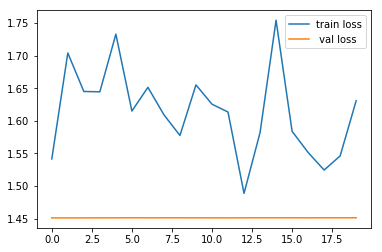

In [24]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

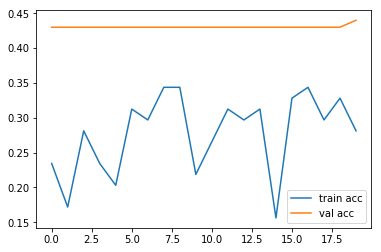

In [25]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Experiment 4

In [26]:
num_epochs=50
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 1.7164 - categorical_accuracy: 0.2031 - val_loss: 1.4695 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-09-1409_18_28.752397/model-00001-1.71638-0.20312-1.46947-0.40000.h5
Epoch 2/50
1/1 [==============================] - 6s 6s/step - loss: 1.6422 - categorical_accuracy: 0.2969 - val_loss: 1.4481 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2020-09-1409_18_28.752397/model-00002-1.64224-0.29688-1.44808-0.45000.h5
Epoch 3/50
1/1 [==============================] - 6s 6s/step - loss: 1.5921 - categorical_accuracy: 0.3438 - val_loss: 1.4495 - val_categorical_accuracy: 0.4700

Epoch 00003: saving model to model_init_2020-09-1409_18_28.752397/model-00003-1.59208-0.34375-1.44949-0.47000.h5
Epoch 4/50
1/1 [==============================] - 7s 7s/step - loss: 1.7299 - categorical_accuracy: 0.2188 - val_loss: 1.4524 - val_categorical_accuracy: 0.4100

Epoch 00004: 

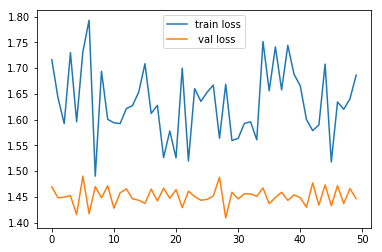

In [28]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

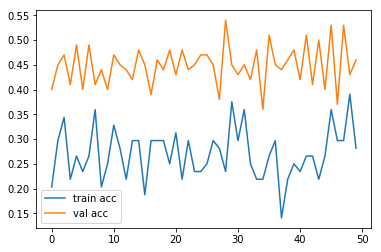

In [29]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Experiment 5

Seems like model is not able to train upto the mark. Addidng data Augmentation to improve training.

In [7]:
import cv2
# Parameters initialization
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
nb_frames = 30  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

Creating new generator to add augmented data by adding data and taking all 30 fromes for training.

In [8]:
def data_processing(source_path, folder_list, batch_num, batch_size, t,validation):
    
    batch_data = batch_data_aug = batch_data_flip = np.zeros((batch_size, nb_frames, 120, 120, 3)) 
    batch_labels = batch_labels_aug = batch_labels_flip = np.zeros((batch_size,5))
    
    
    img_idx = [x for x in range(0, nb_frames)] 

    for folder in range(batch_size):
        
        imgs = os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])
        
        # Generate a random affine to be used in image transformation for buidling agumented data set
        dx, dy = np.random.randint(-1, 1, 2)
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        
        for idx, item in enumerate(img_idx): 
            image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            if image.shape[1] == 160:
                image = image[:,20:140,:].astype(np.float32)
            else:
                image = imresize(image,(120,120)).astype(np.float32)
            
            resized = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
            batch_data[folder,idx] = (resized)
            
            #Affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized, M, (resized.shape[0], resized.shape[1])))
            
            #Horizontal flip
            batch_data_flip[folder,idx]= np.flip(resized,1)

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
        if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
        elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
        else:
                    batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
                  
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
    batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 
    batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
    
    if validation:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
        
    return batch_data_final,batch_labels_final

In [9]:
def generator(source_path, folder_list, batch_size, validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size 
        for batch in range(num_batches): 
            yield data_processing(source_path, folder_list, batch, batch_size, t,validation)
    
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield data_processing(source_path, folder_list, batch, batch_size, t,validation)

In [33]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))

model.add(Dense(nb_dense[1], activation='relu'))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [34]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [11]:
ablation=len(train_doc)
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [12]:
batch_size=20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [38]:
print(steps_per_epoch)
print(validation_steps)

34
5


In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [28]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

Trying with 20 epoch

In [41]:
num_epochs=20
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Source path =  Project_data/valSource path =  Project_data/train ; batch size = 20
 ; batch size = 20
Epoch 1/20
34/34 [==============================] - 213s 6s/step - loss: 2.4413 - categorical_accuracy: 0.2340 - val_loss: 2.0148 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-09-1409_52_12.309268/model-00001-2.45116-0.23429-2.01476-0.23000.h5
Epoch 2/20
34/34 [==============================] - 16s 460ms/step - loss: 2.3508 - categorical_accuracy: 0.2680 - val_loss: 2.0788 - val_categorical_accuracy: 0.0500

Epoch 00002: saving model to model_init_2020-09-1409_52_12.309268/model-00002-2.35085-0.26797-2.07876-0.05000.h5
Epoch 3/20
34/34 [==============================] - 19s 548ms/step - loss: 2.1618 - categorical_accuracy: 0.2190 - val_loss: 1.9800 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2020-09-1409_52_12.309268/model-00003-2.16184-0.21895-1.98001-0.41000.h5
Epoch 4/20
34/34 [==============================] - 18s 5

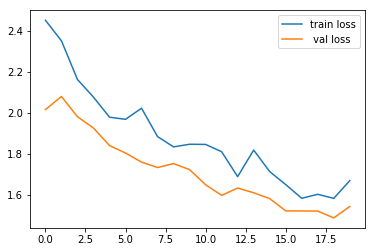

In [43]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

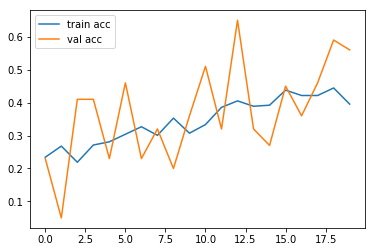

In [44]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

Epoch 150

In [45]:
#Curiosity again let play
num_epochs=150
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Epoch 1/150
34/34 [==============================] - 21s 613ms/step - loss: 1.5651 - categorical_accuracy: 0.4510 - val_loss: 1.5635 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2020-09-1409_52_12.309268/model-00001-1.56509-0.45098-1.56354-0.48000.h5
Epoch 2/150
34/34 [==============================] - 21s 621ms/step - loss: 1.5231 - categorical_accuracy: 0.4935 - val_loss: 1.4317 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2020-09-1409_52_12.309268/model-00002-1.52315-0.49346-1.43171-0.56000.h5
Epoch 3/150
34/34 [==============================] - 21s 623ms/step - loss: 1.4116 - categorical_accuracy: 0.4608 - val_loss: 1.5125 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-09-1409_52_12.309268/model-00003-1.41160-0.46078-1.51245-0.61000.h5
Epoch 4/150
34/34 [==============================] - 20s 595ms/step - loss: 1.5007 - categorical_accuracy: 0.5229 - val_loss: 1.6337 - val_categorical_acc

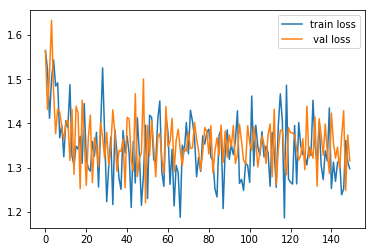

In [46]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

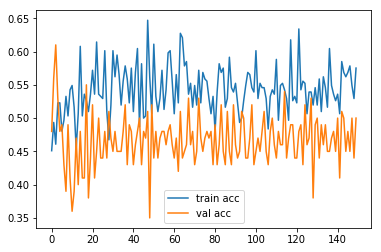

In [47]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Experiment 6

In [48]:
num_epochs=20
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Epoch 1/20
34/34 [==============================] - 21s 614ms/step - loss: 1.3435 - categorical_accuracy: 0.5425 - val_loss: 1.4312 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-09-1409_52_12.309268/model-00001-1.34351-0.54248-1.43117-0.44000.h5
Epoch 2/20
34/34 [==============================] - 20s 600ms/step - loss: 1.2275 - categorical_accuracy: 0.5719 - val_loss: 1.2996 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-09-1409_52_12.309268/model-00002-1.22750-0.57190-1.29960-0.50000.h5
Epoch 3/20
34/34 [==============================] - 20s 600ms/step - loss: 1.3657 - categorical_accuracy: 0.5196 - val_loss: 1.3426 - val_categorical_accuracy: 0.4800

Epoch 00003: saving model to model_init_2020-09-1409_52_12.309268/model-00003-1.36566-0.51961-1.34264-0.48000.h5
Epoch 4/20
34/34 [==============================] - 20s 588ms/step - loss: 1.4503 - categorical_accuracy: 0.5261 - val_loss: 1.3460 - val_categorical_accurac

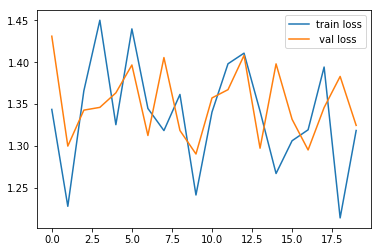

In [50]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

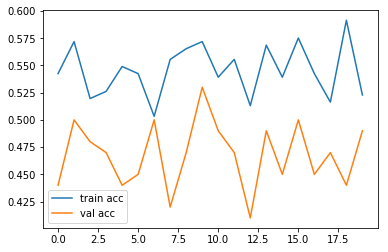

In [51]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Experiment 7

# Tried elu activation instead of relu

In [53]:
#Trail Model can be deleted
# Input
input_shape=(30,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('elu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='elu'))
#model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [54]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_10 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [55]:
num_epochs=50
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Epoch 1/50
34/34 [==============================] - 22s 646ms/step - loss: 2.8822 - categorical_accuracy: 0.2647 - val_loss: 1.7897 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-09-1409_52_12.309268/model-00001-2.88220-0.26471-1.78975-0.54000.h5
Epoch 2/50
34/34 [==============================] - 18s 519ms/step - loss: 2.1794 - categorical_accuracy: 0.3627 - val_loss: 2.2960 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2020-09-1409_52_12.309268/model-00002-2.17943-0.36275-2.29600-0.26000.h5
Epoch 3/50
34/34 [==============================] - 21s 613ms/step - loss: 1.9861 - categorical_accuracy: 0.3693 - val_loss: 2.4099 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_2020-09-1409_52_12.309268/model-00003-1.98607-0.36928-2.40993-0.38000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/50
34/34 [==============================] - 19s 552ms/step - loss: 1

In [ ]:
num_epochs=200
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Epoch 1/200
34/34 [==============================] - 21s 608ms/step - loss: 1.0160 - categorical_accuracy: 0.6863 - val_loss: 1.2893 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-09-1409_52_12.309268/model-00001-1.01600-0.68627-1.28927-0.53000.h5
Epoch 2/200
34/34 [==============================] - 21s 611ms/step - loss: 1.0917 - categorical_accuracy: 0.6797 - val_loss: 1.2877 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-09-1409_52_12.309268/model-00002-1.09171-0.67974-1.28774-0.53000.h5
Epoch 3/200
34/34 [==============================] - 21s 606ms/step - loss: 1.1819 - categorical_accuracy: 0.6307 - val_loss: 1.2871 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2020-09-1409_52_12.309268/model-00003-1.18187-0.63072-1.28713-0.53000.h5
Epoch 4/200
34/34 [==============================] - 21s 608ms/step - loss: 1.1487 - categorical_accuracy: 0.6013 - val_loss: 1.2878 - val_categorical_acc

# Experiment 8

# Trying swish activation instead of relu

In [22]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [23]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [33]:
class swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

In [25]:
#Trail Model can be deleted
# Input
input_shape=(30,120,120,3)

nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]
# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))

model.add(Activation('swish'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('swish'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='swish'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='swish'))
#model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [26]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 16)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 30, 30, 16)     0         
__________

In [38]:
#Not working giving error at the end of 1st epoch
#AttributeError: 'Activation' object has no attribute '__name__'



#num_epochs=5
#r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [37]:
#plot the loss
#plt.plot(r.history['loss'], label = 'train loss' )
#plt.plot(r.history['val_loss'], label = ' val loss')
#plt.legend()
#plt.show()

In [36]:
#plot the accuracy

#plt.plot(r.history['categorical_accuracy'], label='train acc')
#plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
#plt.legend()
#plt.show()

# BELOW are some FAILED MODELS PLEASE IGNORE

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D,ConvLSTM2D,BatchNormalization

model= Sequential()
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),padding="same", return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),padding="same", return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),padding="same", return_sequences=True))
model.add(BatchNormalization())
model.add(Conv3D(filters=1, kernel_size=(3, 3, 3),activation="softmax",padding="same", data_format="channels_last"))
#model.compile(loss="categorical_crossentropy", optimizer="adam")

#model = Sequential()
#model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same', input_shape=(120,120,3)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model.summary())



model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

sample_shape=(15,120,120,3)
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))
    
    
model = Sequential(

Conv3D(32, (3,3,3), activation='relu', input_shape=self.input_shape),
MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)),
Conv3D(64, (3,3,3), activation='relu'),
MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)),
Conv3D(128, (3,3,3), activation='relu'),
Conv3D(128, (3,3,3), activation='relu'),
MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)),
Conv3D(256, (2,2,2), activation='relu'),
Conv3D(256, (2,2,2), activation='relu'),
MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)),

Flatten(),
Dense(1024)),
Dropout(0.5),
Dense(1024),
Dropout(0.5),
Dense(self.nb_classes, activation='softmax')

    
#base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
#x = base_model.output
#x = Flatten()(x)

#features = Dense(64, activation='relu')(x)
#conv_model = Model(inputs=base_model.input, outputs=features)
    
#for layer in base_model.layers:
#    layer.trainable = False
        
#model = Sequential()
#model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
#model.add(GRU(32, return_sequences=True))
#model.add(GRU(16))
#model.add(Dropout(0.1))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(5, activation='softmax'))


curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = 100 #len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = 100 #len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

gen = generator(train_path, train_doc, batch_size,ablation=100)
videos, next_frame = next(gen)
videos[0].shape
next_frame[0].shape

## Model
Here you make the model using different functionalities that Keras provides. You might want to use `TimeDistributed`, `GRU` and other RNN structures after doing transfer learning. Also remember that the last layer is the softmax. Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
print (model.summary())

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Fit data to model
#history = model.fit_generator(train_generator,
#                              steps_per_epoch=steps_per_epoch,
#                             #batch_size=batch_size,
#                              epochs=no_epochs,
#                              verbose=verbosity,
#                              validation_data=val_generator,
#                              validation_steps=validation_steps,
#                              callbacks=callbacks_list)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size,ablation=100)
val_generator = generator(val_path, val_doc, batch_size,ablation=100)

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

import matplotlib.pyplot as plt

#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Model-2
Increased Epoch to 50

 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Model 3

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = 100
print('# training sequences =', num_train_sequences)
num_val_sequences = 100
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.4, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size,ablation=None)
val_generator = generator(val_path, val_doc, batch_size,ablation=None)

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.0001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

print(steps_per_epoch)

 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

# Model 4

import resnet

# specify image size and channels
img_channels = 3
img_rows = 120
img_cols = 120

# number of classes
nb_classes = 5

import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, mode='train', ablation=None, cls=['0','1','2','3','4'], 
                 batch_size=32, dim=(120, 120), n_channels=3, shuffle=True):
        """
        Initialise the data generator
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        
        # glob through directory of each class 
        for i, cls in enumerate(cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
train_generator = generator(train_path, train_doc, batch_size,ablation=None)
val_generator = generator(val_path, val_doc, batch_size,ablation=None)        y = np.delete(y, delete_rows, axis=0)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

train_generator = generator(train_path, train_doc, batch_size,ablation=None)
val_generator = generator(val_path, val_doc, batch_size,ablation=None)

# using resnet 18
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics=['accuracy'])

# create data generator objects in train and val mode
# specify ablation=number of data points to train on
training_generator = train_generator
validation_generator = val_generator

# fit: this will fit the net on 'ablation' samples, only 1 epoch
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# using resnet 18
base_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics=['accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size,ablation=100)
val_generator = generator(val_path, val_doc, batch_size,ablation=100)

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.0001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(100/batch_size)
else:
    steps_per_epoch = (100//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(100/batch_size)
else:
    validation_steps = (100//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

print(steps_per_epoch)

model.fit_generator(generator=train_generator,
                    validation_data=val_generator,
                    epochs=1,steps_per_epoch=2,validation_steps=2)

 r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()